# Imports/Libraries


In [1]:
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import cudf
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
import datetime
import xgboost as xgb

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

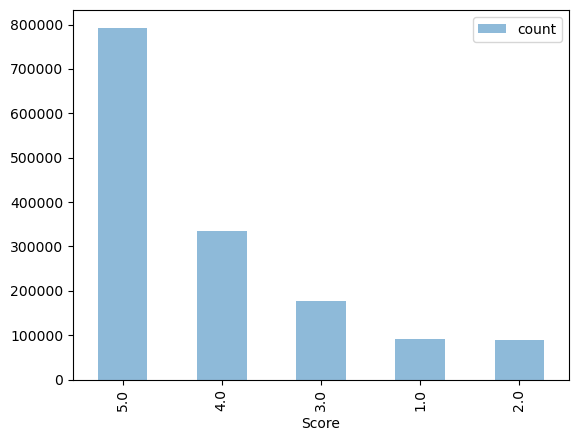


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [3]:
def preprocess(df):
    # This is where you can do all your feature extraction

    for col_name, dtype in df.dtypes.items():
        print(f"Column: {col_name}, Data Type: {dtype}")

    df['Helpfulness'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['UserId']  = LabelEncoder().fit_transform(df['UserId'])
    df['ProductId'] = LabelEncoder().fit_transform(df['ProductId'])

    df['day'] = df['Time'].apply(lambda x: datetime.datetime.fromtimestamp(x).weekday())
    df['is_weekend'] = df['day'].apply(lambda x: 1 if x >= 5 else 0)
    df['hour'] = df['Time'].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)

    df['words'] = df['Text'].apply(lambda x: len(str(x).split()))
    df['wordlengths'] = df['Text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
    df['exclamations'] = df['Text'].apply(lambda x: str(x).count('!'))
    df['questions'] = df['Text'].apply(lambda x: str(x).count('?'))

    print("getting pretentious")
    pretentious= ["shot", "composition", "cinematography", "soundtrack", "direction", "color", "grading", "mixing", "mastering", 
                  "adr", "opus", "kino", "bloated", "overwrought", "pedantic", "kafkaesque", "objectively", "clich", "nonetheless", 
                  "protagonist", "unoriginal", "derivative", "juxtaposition", "symbolism", "spectacle", "motif", "visual language", 
                  "aesthetic", "pathos", "allegory", "postmodern", "opaque", "uninspired", "thematically", "impressionistic", "deconstruction", 
                  "visceral", "macabre", "idiosyncratic", "guttural", "trite", "ambiguity", "gratuitous", "convoluted", "existential", 
                  "moralizing", "cacophony", "stylized", "hauntingly beautiful", "dreamlike", "contrived", "sophomoric", "overindulgent", 
                  "understated", "plodding", "ornate", "brevity", "satirical", "cathartic", "overstimulated", "pontifical", "cerebral", 
                  "hyperbolic", "monolithic", "clumsy metaphor", "incoherent narrative", "emblematic", "endemic clichés", "self-indulgent", 
                  "dystopian", "pretentious dialogue", "ill-conceived"]
    vectorizer = CountVectorizer(vocabulary=pretentious)

    word_counts = vectorizer.fit_transform(df['Text'].fillna(''))

    word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
    df['Pretentiousness'] = word_counts_df.sum(axis=1)
    print("pretentious now this is peak")

    analyzer = SentimentIntensityAnalyzer()
    
    def vader_scores(text):
        scores = analyzer.polarity_scores(text)
        return scores['pos'], scores['neg'], scores['neu'], scores['compound']
    
    print("starting summary sentiment")
    summsent = Parallel(n_jobs=-1)(delayed(vader_scores)(text) for text in tqdm(df['Summary'].fillna(''), desc="Processing VADER Sentiment"))
    df[['summ_pos', 'summ_neg', 'summ_neu', 'summ_compound']] = pd.DataFrame(summsent, index=df.index)

    print("starting text sentiment")
    textsent = Parallel(n_jobs=-1)(delayed(vader_scores)(text) for text in tqdm(df['Text'].fillna(''), desc="Processing VADER Sentiment"))
    df[['text_pos', 'text_neg', 'text_neu', 'text_compound']] = pd.DataFrame(textsent, index=df.index)

    df['combined_sentiment'] = (0.7 * df['text_compound'] + 0.3 * df['summ_compound'])
    df['pos_neg_ratio'] = df['text_pos'] / (df['text_neg'] + 0.01)
    df['pretentious_sentiment'] = df['Pretentiousness'] * df['text_compound']
    df['helpful_sentiment'] = df['Helpfulness'] * df['combined_sentiment']
    df['excitement'] = df['text_compound'] * df['exclamations']
    df['sent_length'] = df['text_compound'] * df['words']

    numerical_cols = trainingSet.select_dtypes(include=['float64', 'int64']).columns.drop('Id').drop('Score')
    scaler = StandardScaler()
    trainingSet[numerical_cols] = scaler.fit_transform(trainingSet[numerical_cols])

    return df.drop(columns=['Summary', 'Text'])

def postprocess(xtrain, xtest, ytrain, xsub):
     xtrain, xtest, ytrain, xsub = post_averages(xtrain, xtest, ytrain, xsub)
     #xtrain, xtest, ytrain, xsub = post_summarylsa(xtrain, xtest, ytrain, xsub)
     #xtrain, xtest, ytrain, xsub = post_textlsa(xtrain, xtest, ytrain, xsub)
     return xtrain, xtest, ytrain, xsub

def post_averages(xtrain, xtest, ytrain, xsub):
    xtrain = xtrain.copy()
    xtrain['Score'] = ytrain

    product_avg_score = xtrain.groupby('ProductId', as_index=False)['Score'].mean()
    product_avg_score = product_avg_score.rename(columns={'Score': 'Product_Avg_Score'})

    product_avg_help = xtrain.groupby('ProductId', as_index=False)['Helpfulness'].mean()
    product_avg_help = product_avg_help.rename(columns={'Helpfulness': 'Product_Avg_Help'})

    product_avg_sent = xtrain.groupby('ProductId', as_index=False)['text_compound'].mean()
    product_avg_sent = product_avg_sent.rename(columns={'text_compound': 'Product_Avg_Sent'})

    user_avg_score = xtrain.groupby('UserId', as_index=False)['Score'].mean()
    user_avg_score = user_avg_score.rename(columns={'Score': 'User_Avg_Score'})

    user_avg_help = xtrain.groupby('UserId', as_index=False)['Helpfulness'].mean()
    user_avg_help = user_avg_help.rename(columns={'Helpfulness': 'User_Avg_Help'}) 

    user_avg_sent = xtrain.groupby('UserId', as_index=False)['text_compound'].mean()
    user_avg_sent = user_avg_sent.rename(columns={'text_compound': 'User_Avg_Sent'})  

    xtrain = xtrain.drop(columns=['Score']).merge(product_avg_score, on='ProductId', how='left') \
        .merge(user_avg_score, on='UserId', how='left') \
        .merge(user_avg_help, on='UserId', how='left') \
        .merge(user_avg_sent, on='UserId', how='left') \
        .merge(product_avg_help, on='ProductId', how='left') \
        .merge(product_avg_sent, on='ProductId', how='left')

    xtest = xtest.merge(product_avg_score, on='ProductId', how='left') \
        .merge(user_avg_score, on='UserId', how='left') \
        .merge(user_avg_help, on='UserId', how='left') \
        .merge(user_avg_sent, on='UserId', how='left') \
        .merge(product_avg_help, on='ProductId', how='left') \
        .merge(product_avg_sent, on='ProductId', how='left')

    xsub = xsub.merge(product_avg_score, on='ProductId', how='left') \
        .merge(user_avg_score, on='UserId', how='left') \
        .merge(user_avg_help, on='UserId', how='left') \
        .merge(user_avg_sent, on='UserId', how='left') \
        .merge(product_avg_help, on='ProductId', how='left') \
        .merge(product_avg_sent, on='ProductId', how='left')

    xtest['Product_Avg_Score'] = xtest['Product_Avg_Score'].fillna(product_avg_score['Product_Avg_Score'].mean())
    xsub['Product_Avg_Score'] = xsub['Product_Avg_Score'].fillna(product_avg_score['Product_Avg_Score'].mean())

    xtest['Product_Avg_Help'] = xtest['Product_Avg_Help'].fillna(product_avg_help['Product_Avg_Help'].mean())
    xsub['Product_Avg_Help'] = xsub['Product_Avg_Help'].fillna(product_avg_help['Product_Avg_Help'].mean())

    xtest['Product_Avg_Sent'] = xtest['Product_Avg_Sent'].fillna(product_avg_sent['Product_Avg_Sent'].mean())
    xsub['Product_Avg_Sent'] = xsub['Product_Avg_Sent'].fillna(product_avg_sent['Product_Avg_Sent'].mean())

    xtest['User_Avg_Score'] = xtest['User_Avg_Score'].fillna(user_avg_score['User_Avg_Score'].mean())
    xsub['User_Avg_Score'] = xsub['User_Avg_Score'].fillna(user_avg_score['User_Avg_Score'].mean())

    xtest['User_Avg_Help'] = xtest['User_Avg_Help'].fillna(user_avg_help['User_Avg_Help'].mean())
    xsub['User_Avg_Help'] = xsub['User_Avg_Help'].fillna(user_avg_help['User_Avg_Help'].mean())

    xtest['User_Avg_Sent'] = xtest['User_Avg_Sent'].fillna(user_avg_sent['User_Avg_Sent'].mean())
    xsub['User_Avg_Sent'] = xsub['User_Avg_Sent'].fillna(user_avg_sent['User_Avg_Sent'].mean())

    xtrain['Product_helpful_sentiment'] = xtrain['Product_Avg_Help'] * xtrain['Product_Avg_Sent']
    xtest['Product_helpful_sentiment'] = xtest['Product_Avg_Help'] * xtest['Product_Avg_Sent']
    xsub['Product_helpful_sentiment'] = xsub['Product_Avg_Help'] * xsub['Product_Avg_Sent']

    xtrain['user_sentiment_deviation'] = (xtrain['text_compound'] - xtrain['User_Avg_Sent']).abs()

    xtest['user_sentiment_deviation'] = (xtest['text_compound'] - xtest['User_Avg_Sent']).abs()

    xsub['user_sentiment_deviation'] = (xsub['text_compound'] - xsub['User_Avg_Sent']).abs()

    xtest['user_sentiment_deviation'] = xtest['user_sentiment_deviation'].fillna(xtest['user_sentiment_deviation'].mean())
    xsub['user_sentiment_deviation'] = xsub['user_sentiment_deviation'].fillna(xsub['user_sentiment_deviation'].mean())

    return xtrain, xtest, ytrain, xsub


# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = preprocess(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

for col_name, dtype in X_train.dtypes.items():
        print(f"Column: {col_name}, Data Type: {dtype}")

Column: Id, Data Type: int64
Column: ProductId, Data Type: object
Column: UserId, Data Type: object
Column: HelpfulnessNumerator, Data Type: int64
Column: HelpfulnessDenominator, Data Type: int64
Column: Time, Data Type: int64
Column: Summary, Data Type: object
Column: Text, Data Type: object
Column: Score, Data Type: float64
getting pretentious
pretentious now this is peak
starting summary sentiment


Processing VADER Sentiment: 100%|██████████| 1697533/1697533 [00:12<00:00, 138432.64it/s]


starting text sentiment


Processing VADER Sentiment: 100%|██████████| 1697533/1697533 [02:51<00:00, 9888.71it/s] 


Column: Id, Data Type: int64
Column: ProductId, Data Type: float64
Column: UserId, Data Type: float64
Column: HelpfulnessNumerator, Data Type: float64
Column: HelpfulnessDenominator, Data Type: float64
Column: Time, Data Type: float64
Column: Score, Data Type: float64
Column: Helpfulness, Data Type: float64
Column: day, Data Type: float64
Column: is_weekend, Data Type: float64
Column: hour, Data Type: float64
Column: words, Data Type: float64
Column: wordlengths, Data Type: float64
Column: exclamations, Data Type: float64
Column: questions, Data Type: float64
Column: Pretentiousness, Data Type: float64
Column: summ_pos, Data Type: float64
Column: summ_neg, Data Type: float64
Column: summ_neu, Data Type: float64
Column: summ_compound, Data Type: float64
Column: text_pos, Data Type: float64
Column: text_neg, Data Type: float64
Column: text_neu, Data Type: float64
Column: text_compound, Data Type: float64
Column: combined_sentiment, Data Type: float64
Column: pos_neg_ratio, Data Type: flo

# Sample + Split into training and testing set

In [4]:
# Split training set into training and testing set

#X_sample = X_train.sample(frac=0.1, random_state=0)
X_sample = X_train.copy()
X_train, X_test, Y_train, Y_test = train_test_split(
    X_sample.drop(columns=['Score']),
    X_sample['Score'],
    test_size=1/8.0,
    random_state=0
)
#calculate averages post-split to ensure no cheating
X_train, X_test, Y_train, X_submission = postprocess(X_train, X_test, Y_train, X_submission)

# Feature Selection

In [5]:
features = ['HelpfulnessNumerator','HelpfulnessDenominator', 'Helpfulness', 
            'Product_Avg_Score', 'User_Avg_Score', 'Pretentiousness',
            'text_pos', 'text_neg', 'text_neu', 'text_compound',
            'summ_pos', 'summ_neg', 'summ_neu', 'summ_compound',
            'day', 'hour', 'words', 'wordlengths', 'exclamations',
            'is_weekend', 'combined_sentiment', 'pos_neg_ratio',
            'pretentious_sentiment', 'helpful_sentiment', 'excitement', 'sent_length', 
            'Product_Avg_Help', 'Product_Avg_Sent','User_Avg_Help','User_Avg_Sent', 
            'Product_helpful_sentiment', 'user_sentiment_deviation']


X_train_select = X_train[features].copy()
X_test_select = X_test[features].copy()
X_submission_select = X_submission[features].copy()

correlations = pd.DataFrame(X_train_select).corrwith(Y_train).abs()
print(correlations.sort_values(ascending=False))

Product_helpful_sentiment    0.001779
wordlengths                  0.001761
user_sentiment_deviation     0.001701
summ_neu                     0.001628
Product_Avg_Help             0.001300
summ_pos                     0.001212
Pretentiousness              0.001135
day                          0.001104
User_Avg_Score               0.001100
exclamations                 0.001044
text_pos                     0.000979
hour                         0.000943
User_Avg_Help                0.000899
User_Avg_Sent                0.000895
text_neg                     0.000869
sent_length                  0.000843
summ_compound                0.000810
text_compound                0.000779
Product_Avg_Sent             0.000692
is_weekend                   0.000671
summ_neg                     0.000624
text_neu                     0.000599
Product_Avg_Score            0.000593
helpful_sentiment            0.000582
combined_sentiment           0.000507
HelpfulnessNumerator         0.000483
pos_neg_rati

# Model Creation

In [6]:
cudf_xtrain = cudf.DataFrame.from_pandas(X_train_select).astype('float32')
cudf_ytrain = cudf.Series((Y_train-1).astype(int))
cudf_xtestselect=cudf.DataFrame.from_pandas(X_test_select).astype('float32')
cudf_xsubmissionselect=cudf.DataFrame.from_pandas(X_submission_select).astype('float32')

dtrain = xgb.DMatrix(data=cudf_xtrain, label=cudf_ytrain)
dtest = xgb.DMatrix(data=cudf_xtestselect)
dsub = xgb.DMatrix(data=cudf_xsubmissionselect)

In [7]:
params = {
    'device': 'cuda',   
    'objective': 'multi:softprob', 
    'num_class': 5,   
    'learning_rate': 0.047322699489939835, #searched
    'max_depth': 13,
    'random_state': 0,
    'colsample_bytree': 0.6,
    'min_child_weight': 10,
}
num_boost_round = 1000
xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

Y_test_predictions_proba = xgb_model.predict(dtest)
grd_pred = Y_test_predictions_proba.argmax(axis=1) + 1

# Model Evaluation

Accuracy on testing set =  0.6333563134196523


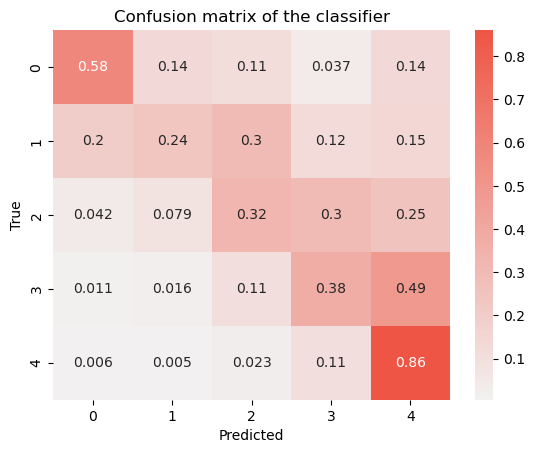

In [8]:
# Evaluate your model on the testing set
#pred = Forest_test_predictions.to_numpy()
#pred = KNN_test_predictions
pred = grd_pred

print("Accuracy on testing set = ", accuracy_score(Y_test, pred))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, pred, normalize='true')
sns.heatmap(cm, annot=True, cmap=sns.light_palette("#e54", as_cmap=True))
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [10]:
# Create the submission file
sub_proba = xgb_model.predict(dsub)
sub_pred = sub_proba.argmax(axis=1) + 1

X_submission['Score'] = sub_pred.astype(float)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)